In [1]:
# Library for Data Preparation
import pandas as pd
import re

# Library for Classificaton Model
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader

from transformers import (
    set_seed,
    GPT2Config,
    GPT2Tokenizer,
    GPT2ForSequenceClassification,
    AdamW,
    get_cosine_schedule_with_warmup,
    TrainingArguments,
    Trainer,
)

from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/home/anaconda3/envs/aung/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# data

In [2]:
! git clone https://github.com/rewire-online/edos.git 

fatal: destination path 'edos' already exists and is not an empty directory.


In [3]:
# Define the path to the CSV files
csv_labelled_aggregated = 'edos/data/edos_labelled_aggregated.csv'
csv_labelled_individual_annotations = 'edos/data/edos_labelled_individual_annotations.csv'
csv_gab_unlabelled = 'edos/data/gab_1M_unlabelled.csv'
csv_reddit_unlabelled = 'edos/data/reddit_1M_unlabelled.csv'

In [4]:
# Read labelled data
data_labelled_1 = pd.read_csv(csv_labelled_aggregated)
data_labelled_1.head()

,rewire_id,text,label_sexist,label_category,label_vector,split
0,sexism2022_english-9609,"In Nigeria, if you rape a woman, the men rape ...",not sexist,none,none,dev
1,sexism2022_english-16993,"Then, she's a keeper. 😉",not sexist,none,none,train
2,sexism2022_english-13149,This is like the Metallica video where the poo...,not sexist,none,none,train
3,sexism2022_english-13021,woman?,not sexist,none,none,train
4,sexism2022_english-966,I bet she wished she had a gun,not sexist,none,none,dev


In [5]:
# Read labelled data
data_labelled_2 = pd.read_csv(csv_labelled_individual_annotations)
data_labelled_2 = data_labelled_2.drop(columns=['annotator'], inplace=False)
data_labelled_2.head()

,rewire_id,text,label_sexist,label_category,label_vector,split
0,sexism2022_english-0,[USER] I wonder what keeps that witch looking ...,sexist,2. derogation,2.2 aggressive and emotive attacks,train
1,sexism2022_english-0,[USER] I wonder what keeps that witch looking ...,sexist,2. derogation,2.2 aggressive and emotive attacks,train
2,sexism2022_english-0,[USER] I wonder what keeps that witch looking ...,not sexist,none,none,train
3,sexism2022_english-1,"What do you guys think about female ""incels""? ...",not sexist,none,none,train
4,sexism2022_english-1,"What do you guys think about female ""incels""? ...",not sexist,none,none,train


In [6]:
# Concat data_labelled_1 and data_labelled_2
data_labelled = pd.concat([data_labelled_1, data_labelled_2])
data_labelled.count()

rewire_id         80000
text              80000
label_sexist      80000
label_category    80000
label_vector      80000
split             80000
dtype: int64

In [7]:
# Load data for Task C
selected_columns_taskC = ['text', 'label_vector', 'split']
data_labelled_taskC = data_labelled[selected_columns_taskC]
data_labelled_taskC.head()

,text,label_vector,split
0,"In Nigeria, if you rape a woman, the men rape ...",none,dev
1,"Then, she's a keeper. 😉",none,train
2,This is like the Metallica video where the poo...,none,train
3,woman?,none,train
4,I bet she wished she had a gun,none,dev


In [8]:
# Split into Train, Validate and Test
data_train_taskC = data_labelled_taskC[data_labelled_taskC['split'] == 'train']
data_train_taskC = data_train_taskC.drop('split', axis=1)
print("Train Data:\n", data_train_taskC.count(), "\n")

data_val_taskC = data_labelled_taskC[data_labelled_taskC['split'] == 'dev']
data_val_taskC = data_val_taskC.drop('split', axis=1)
print("Validation Data:\n", data_val_taskC.count(), "\n")

data_test_taskC = data_labelled_taskC[data_labelled_taskC['split'] == 'test']
data_test_taskC = data_test_taskC.drop('split', axis=1)
print("Test Data:\n", data_test_taskC.count())

Train Data:
 text            56000
label_vector    56000
dtype: int64 

Validation Data:
 text            8000
label_vector    8000
dtype: int64 

Test Data:
 text            16000
label_vector    16000
dtype: int64


In [10]:
#drop the none column
index = data_train_taskC[ (data_train_taskC['label_vector'] == 'none')  ].index
data_train_taskC.drop(index , inplace=True)

index = data_val_taskC[ (data_val_taskC['label_vector'] == 'none')  ].index
data_val_taskC.drop(index , inplace=True)

index = data_test_taskC[ (data_test_taskC['label_vector'] == 'none')  ].index
data_test_taskC.drop(index , inplace=True)

print("Train Data:\n", data_train_taskC.count(), "\n")
print("Validation Data:\n", data_val_taskC.count(), "\n")
print("Test Data:\n", data_test_taskC.count())

Train Data:
 text            10399
label_vector    10399
dtype: int64 

Validation Data:
 text            1905
label_vector    1905
dtype: int64 

Test Data:
 text            3799
label_vector    3799
dtype: int64


## clean

In [11]:
def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    text=re.sub(r'[^\w\s]','',text)
    text=text.replace("[URL]","")
    text=text.replace("[USER]","")
    text=re.sub(r"[â€™ºðŸ‡˜Žµ±¤£‘Œ”œ]","",text)
    return text

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):

    text = remove_between_square_brackets(text)
    return text

# to make all texts lowercase
def to_lowercase(input_text):

    return input_text.lower()

In [12]:
data_train_taskC['text'] = data_train_taskC['text'].apply(clean_text)
data_train_taskC['text'] = data_train_taskC['text'].apply(denoise_text)
data_train_taskC['text'] = data_train_taskC['text'].apply(to_lowercase)

data_val_taskC['text'] = data_val_taskC['text'].apply(clean_text)
data_val_taskC['text'] = data_val_taskC['text'].apply(denoise_text)
data_val_taskC['text'] = data_val_taskC['text'].apply(to_lowercase)

data_test_taskC['text'] = data_test_taskC['text'].apply(clean_text)
data_test_taskC['text'] = data_test_taskC['text'].apply(denoise_text)
data_test_taskC['text'] = data_test_taskC['text'].apply(to_lowercase)

## to object

In [13]:
data_train_taskC

,text,label_vector
14,o come on theres no way any men are attracted ...,2.3 dehumanising attacks & overt sexual object...
32,i did you have to have the bravery to escalate...,1.2 incitement and encouragement of harm
41,not going to lie the brutal honesty of this re...,4.1 supporting mistreatment of individual women
43,please take my wife rape my daughter but whate...,1.2 incitement and encouragement of harm
46,pink is very feminine so i accept this bikini ...,3.2 immutable gender differences and gender st...
...,...,...
59964,she should be strung up no drop let her kick a...,1.2 incitement and encouragement of harm
59965,she should be strung up no drop let her kick a...,1.2 incitement and encouragement of harm
59966,she should be strung up no drop let her kick a...,1.2 incitement and encouragement of harm
59997,laura bates lol she looks like shed suck the s...,2.2 aggressive and emotive attacks


In [15]:
class SeximsDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        record = self.data.iloc[index]
        text = record['text']
        label = record['label_vector']
        if label == '1.1 threats of harm':
            label = 0
        elif label == '1.2 incitement and encouragement of harm':
            label = 1
        elif label == '2.1 descriptive attacks':
            label = 2
        elif label == '2.2 aggressive and emotive attacks':
            label = 3
        elif label == '2.3 dehumanising attacks & overt sexual objectification':
            label = 4
        elif label == '3.1 casual use of gendered slurs, profanities, and insults':
            label = 5
        elif label == '3.2 immutable gender differences and gender stereotypes':
            label = 6
        elif label == '3.3 backhanded gendered compliments':
            label = 7
        elif label == '3.4 condescending explanations or unwelcome advice':
            label = 8
        elif label == '4.1 supporting mistreatment of individual women':
            label = 9
        else:
            label = 10
        return {'text': text, 'label': label} 

In [16]:
train_dataset = SeximsDataset(data_train_taskC)
val_dataset = SeximsDataset(data_val_taskC)
test_dataset = SeximsDataset(data_test_taskC)

# Train

In [17]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

In [18]:
class Gpt2ClassificationCollator(object):
    def __init__(self, tokenizer, max_seq_len=None):
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        return
    
    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        labels = [int(sequence['label']) for sequence in sequences]
        inputs = self.tokenizer(
            text=texts,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=self.max_seq_len,
        )
        inputs.update({'labels': torch.tensor(labels)})
        return inputs

In [19]:
gpt2_classification_collator = Gpt2ClassificationCollator(tokenizer, max_seq_len=256)

In [20]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=gpt2_classification_collator,
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=gpt2_classification_collator,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=gpt2_classification_collator,
)

In [21]:
set_seed(36)
model_config = GPT2Config.from_pretrained("gpt2", num_labels=11)
model = GPT2ForSequenceClassification.from_pretrained("gpt2", config=model_config)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
TOTAL_EPOCHS = 5

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay': 0.01,
    },
    {
        'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay': 0.0,
    }
]
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=1e-5,
    eps=1e-8,
)

num_training_steps = TOTAL_EPOCHS * len(train_dataloader)
num_warmup_steps = int(0.1 * num_training_steps)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
)

/home/anaconda3/envs/aung/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
def train(dataloader, optimizer, scheduler, device_):
    global model
    model.train()

    predictions_labels = []
    true_labels = []

    total_loss = []

    for batch in dataloader:
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k: v.type(torch.long).to(device_) for k, v in batch.items()}

        outputs = model(**batch)
        loss, logits = outputs[:2]
        logits = logits.detach().cpu().numpy()
        total_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        predictions_labels += logits.argmax(axis=-1).flatten().tolist()

    return true_labels, predictions_labels, total_loss

def validation(dataloader, device_):
    global model
    model.eval()

    predictions_labels = []
    true_labels = []

    total_loss = []

    for batch in dataloader:
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k: v.type(torch.long).to(device_) for k, v in batch.items()}

        with torch.no_grad():
            outputs = model(**batch)
            loss, logits = outputs[:2]
            logits = logits.detach().cpu().numpy()
            total_loss.append(loss.item())

        predictions_labels += logits.argmax(axis=-1).flatten().tolist()
    return true_labels, predictions_labels, total_loss

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

all_loss = {'train_loss': [], 'val_loss': []}
all_acc = {'train_acc': [], 'val_acc': []}

for epoch in range(TOTAL_EPOCHS):
    y, y_pred, train_loss = train(train_dataloader, optimizer, lr_scheduler, device)

    train_acc = accuracy_score(y, y_pred)

    y, y_pred, val_loss = validation(val_dataloader, device)
    val_acc = accuracy_score(y, y_pred)

    all_loss['train_loss'] += train_loss
    all_loss['val_loss'] += val_loss

    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)

    print(f'Epoch: {epoch}, train_loss: {torch.tensor(train_loss).mean():.3f}, train_acc: {train_acc:.3f}, val_loss: {torch.tensor(val_loss).mean():.3f}, val_acc: {val_acc:.3f}')

    model.save_pretrained('./')
    tokenizer.save_pretrained('./')

Epoch: 0, train_loss: 2.525, train_acc: 0.195, val_loss: 2.022, val_acc: 0.289
Epoch: 1, train_loss: 1.995, train_acc: 0.301, val_loss: 1.871, val_acc: 0.327
Epoch: 2, train_loss: 1.861, train_acc: 0.341, val_loss: 1.793, val_acc: 0.351
Epoch: 3, train_loss: 1.791, train_acc: 0.367, val_loss: 1.767, val_acc: 0.369
Epoch: 4, train_loss: 1.763, train_acc: 0.379, val_loss: 1.759, val_acc: 0.379


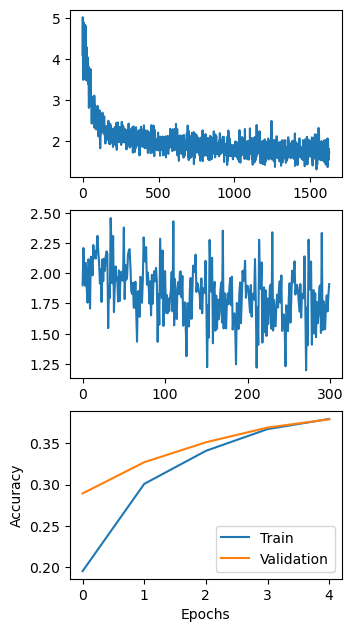

In [25]:
fig = plt.figure(figsize=(3.5, 10))

a = fig.add_subplot(4, 1, 1)
b = fig.add_subplot(4, 1, 2)
c = fig.add_subplot(4, 1, 3)

a.plot(all_loss['train_loss'], label='Train Loss')
b.plot(all_loss['val_loss'], label='Val Loss')
c.plot(all_acc['train_acc'], label='Train Accuracy')
c.plot(all_acc['val_acc'], label='Val Accuracy')
c.set(xlabel='Epochs', ylabel='Accuracy')
c.legend(['Train', 'Validation'])

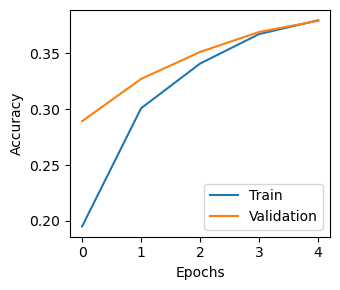

In [26]:
import matplotlib.pyplot as plt

# Assuming all_acc is a dictionary containing training and validation accuracy data
fig, c = plt.subplots(figsize=(3.5, 3))

c.plot(all_acc['train_acc'], label='Train Accuracy')
c.plot(all_acc['val_acc'], label='Validation Accuracy')

c.set(xlabel='Epochs', ylabel='Accuracy')
c.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

In [27]:
test_y, test_y_pred, test_val_loss =validation(test_dataloader, device)
test_val_acc = accuracy_score(test_y, test_y_pred)
print(f'Test Loss: {torch.tensor(test_val_loss).mean():.3f}, Test Accuracy: {test_val_acc:.3f}')

Test Loss: 1.745, Test Accuracy: 0.380
